In [3]:
import numpy as np
import pandas as pd
from numpy import sqrt, e, log
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
def convert_zero(x):
    if x == 0:
        x = -1
    return x

df = pd.read_csv('data.csv') 
df['HeartDiseaseorAttack'] = df['HeartDiseaseorAttack'].apply(lambda x: int(x))
df['HeartDiseaseorAttack'] = df['HeartDiseaseorAttack'].apply(convert_zero)

In [28]:
len(df)/2

126840.0

In [5]:
df

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,-1,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,-1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,-1,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,-1,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,-1,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,-1,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,-1,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,-1,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,-1,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [6]:
def point_margin(x, alpha, h):
    """
    Calculate the margin of a point
    Args:
        x:      point
        alpha:  weights
        h:      classifiers
    """
    alpha_l1 = np.linalg.norm(alpha, ord=1)
    T = len(h)
    f = 0
    for i in range(T):
        f = alpha[i] * h[i].predict(x)
    margin = np.abs(f) / alpha_l1
    return margin

def sample_margin(X, alpha, h):
    """
    Calculate the margin of a sample
    Args:
        X:      sample
        alpha:  weights
        h:      classifiers
    """
    m = X.shape[0]
    margin = float('+inf')
    for i in range(m):
        x = X[i].reshape(1, -1)
        margin = min(margin, point_margin(x, alpha, h))
    return margin

def get_error_bound(rho, d, m, delta):
    """
    Calculate the error bound
    Args:
        rho:    margin
        d:      VC dimension
        m:      sample size
        delta:  confidence
    """
    first_term = sqrt((2 * d * log(e * m / d)) / m) * 2 / rho
    second_term = sqrt(log(1 / delta) / (2 * m))
    return first_term + second_term

delta = 0.05
def evaluate_error(df, delta):
    """
    Evaluate the error of the AdaBoost classifier
    Args:
        m:      sample size
        d:      VC dimension
        delta:  confidence
        T:      number of iterations
    """
    # Create the dataset
    X = df.drop(columns=['HeartDiseaseorAttack'])
    y = df['HeartDiseaseorAttack']

    X_train, X_test, y_test, y_train = train_test_split(X,y, test_size = 0.5)
    
    m = len(X_train)
    d = len(X_train.columns)
    
    X_train=X_train.to_numpy()
    X_test=X_test.to_numpy()
    y_train=y_train.to_numpy()
    y_test=y_test.to_numpy()

    # Train the AdaBoostClassifier with Perceptron base estimator
    clf = AdaBoostClassifier(
        base_estimator=Perceptron(penalty=None),
       # n_estimators=T,
        algorithm='SAMME',
        random_state=20,
    )
    clf.fit(X_train, y_train)

    alpha = clf.estimator_weights_
    h = clf.estimators_
    rho = sample_margin(X_train, alpha, h)

    R_test = 1 - clf.score(X_test, y_test)
    R_train = 1 - clf.score(X_train, y_train)
    error_bound = get_error_bound(rho, d, m, delta)

    return R_test, R_train, error_bound#, rho

In [9]:
evaluate_error(df, delta)

(0.09803689687795647, 0.09742194891201517, array([0.11682003]))

In [106]:
list(X_train.columns)

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'Diabetes',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

In [221]:
range_t = range(1, 30)
test_errors, train_errors = [0] * 30, [0] * 30
n_iter = 100

cols1 = ['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'Diabetes',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'HeartDiseaseorAttack']

df1 = df.iloc[:, :int(len(df)/2)]
df1 = df1[cols1]
for j in tqdm(range(n_iter)):
    #X_train, X_test, y_train, y_test = create_dataset(m, d, class_sep=0.5, random_state=j+1337)
    c = 0
    for T in range_t:
        try:
            R_test, R_train = evaluate_error(df1, delta)
            test_errors[T] += R_test
            train_errors[T] += R_train
            c+=1
        except:
            pass
test_errors = [e / n_iter for e in test_errors[1:]]
train_errors = [e / n_iter for e in train_errors[1:]]
df_number_of_trees = pd.DataFrame({
    'T': range_t[:len(train_errors)],
    'test_error': test_errors,
    'train_error': train_errors#.append(0)
}).to_csv(f'experiment_T{0}.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████| 100/100 [10:37<00:00,  6.38s/it]


In [222]:
range_t = range(1, 30)
test_errors, train_errors = [0] * 30, [0] * 30
n_iter = 100

df2 = df
for j in tqdm(range(n_iter)):
    c = 0
    #X_train, X_test, y_train, y_test = create_dataset(m, d, class_sep=0.5, random_state=j+1337)
    for T in range_t:
        try:
            R_test, R_train = evaluate_error(df2, delta)
            test_errors[T] += R_test
            train_errors[T] += R_train
            c+=1
        except:
            pass
test_errors = [e / n_iter for e in test_errors[1:]]
train_errors = [e / n_iter for e in train_errors[1:]]
df_number_of_trees = pd.DataFrame({
    'T': range_t[:len(train_errors)],
    'test_error': test_errors,
    'train_error': train_errors#.append(0)
}).to_csv(f'experiment_T{1}.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████| 100/100 [23:14<00:00, 13.94s/it]


In [11]:
import matplotlib.font_manager
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

/raid/kaisar_dauletbek/espnet/tools/anaconda/envs/espnet/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/raid/kaisar_dauletbek/espnet/tools/anaconda/envs/espnet/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/raid/kaisar_dauletbek/espnet/tools/anaconda/envs/espnet/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/raid/kaisar_dauletbek/espnet/tools/anaconda/

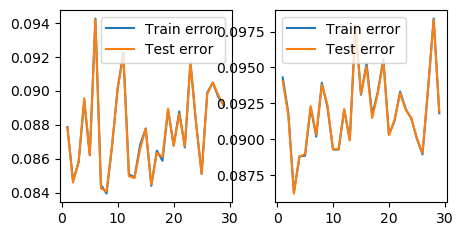

In [223]:
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
df_experiment_T0 = pd.read_csv('experiment_T0.csv')
df_experiment_T1 = pd.read_csv('experiment_T1.csv')

ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(
    data=df_experiment_T0,
    y='test_error',
    x='T',
    ax=ax1,
)
sns.lineplot(
    data=df_experiment_T0,
    y='train_error',
    x='T',
    ax=ax1,
)
ax1.legend(['Train error', 'Test error'])
ax1.set_ylabel('') 
ax1.set_xlabel('')

ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(
    data=df_experiment_T1,
    y='test_error',
    x='T',
    ax=ax2,
)
sns.lineplot(
    data=df_experiment_T1,
    y='train_error',
    x='T',
    ax=ax2,
)
ax2.legend(['Train error', 'Test error'])
ax2.set_ylabel('') 
ax2.set_xlabel('')

plt.savefig("experiment_T.svg", format="svg", bbox_inches='tight')
plt.show()

# Experiment for m

In [12]:
#errors_test = []
#errors_train = []
error_bounds = []
errors_diff = []

exceptions = 0
indices = []


for i in tqdm(range(100, len(df), 100)):
    df_exp = df[:][:i]
    try:
        R_test, R_train, error_bound = evaluate_error(df_exp, 0.05)
        #errors_test.append(R_test)
        #errors_train.append(R_train)
        errors_diff.append(abs(R_test-R_train))
        error_bounds.append(error_bound)
        indices.append(i)
    except:
        exceptions += 1
        pass

100%|███████████████████████████████████████████████████████████████████| 2536/2536 [5:52:04<00:00,  8.33s/it]


In [18]:
df_error_bounds_m = pd.DataFrame()
df_experiment_m = pd.DataFrame()

#error_bounds_exp = [i/len(error_bounds) for i in error_bounds]
df_error_bounds_m['m'] = indices
df_error_bounds_m['error'] = error_bounds
df_error_bounds_m['error'] = df_error_bounds_m['error'].apply(lambda x: x[0])

df_experiment_m['m'] = indices
df_experiment_m['error'] = errors_diff

In [17]:
def change(x):
    if x>1:
        x = 1
    return x
df_error_bounds_m['error'] = df_error_bounds_m['error'].apply(change)

In [19]:
error_bounds_sep = [get_error_bound(10, 21, m, 0.05) for m in tqdm(indices)]

100%|█████████████████████████████████████████████████████████████████| 2311/2311 [00:00<00:00, 157715.49it/s]


In [26]:
df_bounds_m = pd.DataFrame()
df_bounds_m['bound'] = error_bounds_sep
df_bounds_m.to_csv('bounds_m.csv')

In [31]:
df_experiment_m['bound'] = error_bounds_sep
df_experiment_m['m'] = df_experiment_m['m'].apply(lambda x: x//2)
df_experiment_m.to_csv('experiment_m.csv')

/raid/kaisar_dauletbek/espnet/tools/anaconda/envs/espnet/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/raid/kaisar_dauletbek/espnet/tools/anaconda/envs/espnet/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/raid/kaisar_dauletbek/espnet/tools/anaconda/envs/espnet/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


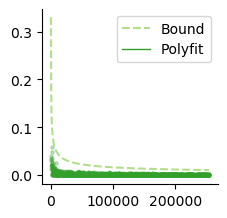

In [20]:
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
# df_error_bounds_m = pd.read_csv('data/error_bounds_m.csv')
# df_experiment_m = pd.read_csv('data/experiment_m.csv')

palette = sns.color_palette("Paired")
    
d = len(df.columns)
ax = fig.add_subplot(2, 2, 1,)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
error_line = sns.lineplot(
    x=df_error_bounds_m['m'],
    y=error_bounds_sep,#df_error_bounds_m['error'],
    color=palette[2],
    linestyle='dashed',
)
fit_line = sns.regplot(
    data=df_experiment_m,
    x='m',
    y='error',
    order=10,
    line_kws={'color': palette[2+1], "lw": 1},
    scatter_kws={"s": 5, "color": palette[2+1], 'alpha': 0.3},
    ci=100,
    ax=ax,
)
ax.legend(['Bound', 'Polyfit'])
ax.set_ylabel('') 
ax.set_xlabel('')

plt.savefig("experiment_m.svg", format="svg", bbox_inches='tight')
plt.show()